### To install
`pip3 install git+https://github.com/gtcanalytics/randl_client`

In [1]:
import randl_client

### Create an instance of the driver class

In [2]:
randl = randl_client.Randl()

In [3]:
randl

URL:http://seismic-ai.com:8011/randl/

-Bulletin-
Start:		2024-05-01T00:00:00
End:		2024-05-11T00:00:00
Stations:	100
Events:		1
Drop fraction:	0.2
Seed:	555

-Window-
Start:			2024-05-10 18:43:15.431390
Length:			1800
Min_phases:		5
Exclude associated:	False

-DML-
Models:		['pwave']
Sampling:	['full']
Num_samples:	10
Arids:		['None']
Pwave_model:	None
Baz_model:	None
Exclude stations:	True

-Beamsearch-
Beam width:	5
Max dist:	5000
Max time:	500
Sequence dist:	500
Sequence time:	500

### Randl Setter Functions
#### Bulletin Generator

`randl.set_bulletin_start('timestamp')`

`randl.set_bulletin_end('timestamp')`

`randl.set_bulletin_n_stations(int)`

`randl.set_bulletin_n_events(int)`

`randl.set_bulletin_drop_fraction(float)`

`randl.set_bulletin_seed(int)`

`bulletin = randl.create_bulletin()`

#### Windowing

`randl.set_window_start('timestamp')`

`randl.set_window_length(int)`

`randl.set_window_phases_required(int)`

`randl.set_window_exclude_associated_phases(Boolean)`

`window = randl.window_catalog(bulletin_dataframe)`

#### DML Predictions

`randl.set_dml_models(list).` Example: ['pwave', 'baz']

`randl.set_dml_sampling(list).` Example: ['kfn', 'knn', 'full', 'random']

`randl.set_dml_num_samples(int)`

`randl.set_dml_exclude_duplicate_stations(Boolean)`

`randl.set_dml_pwave_model("mlflow_model_path")`

`dml_predictions = randl.dml_prediction(window_dataframe)`

#### Beamsearch

`randl.set_beamwidth(int)`

`randl.set_beam_maxdist(int)`

`randl.set_beam_maxtime(int)`

`randl.set_beam_sequencedist(int)`

`randl.set_beam_sequencetimedist(int)`

`randl.beamsearch(window_dataframe, dml_predictions_dataframe)`

### Example Run

In [4]:
randl.set_bulletin_start('2024-05-01T00:00:00')
randl.set_bulletin_end('2024-05-01T0:30:00')
randl.set_bulletin_n_stations(50)
randl.set_bulletin_n_events(1)
randl.set_bulletin_drop_fraction(0.2)
randl.set_bulletin_seed(555)
bulletin = randl.create_bulletin()

randl.set_window_start(bulletin.loc[0,"TIME_ARRIV"])
randl.set_window_length(1800)
randl.set_window_phases_required(5)
randl.set_window_exclude_associated_phases(False)
window = randl.window_catalog(bulletin)

randl.set_dml_models(['pwave'])
randl.set_dml_sampling(['kfn'])
randl.set_dml_num_samples(30)
randl.set_dml_exclude_duplicate_stations(True)
dml_predictions = randl.dml_prediction(window)

randl.set_beamwidth(5)
randl.set_beam_maxdist(1000)
randl.set_beam_maxtime(100)
randl.set_beam_sequencedist(300)
randl.set_beam_sequencetimedist(100)
centroid, mean_time, mean_score = randl.beamsearch(window, dml_predictions)

Success
Success
Success
Success


### Plotting result

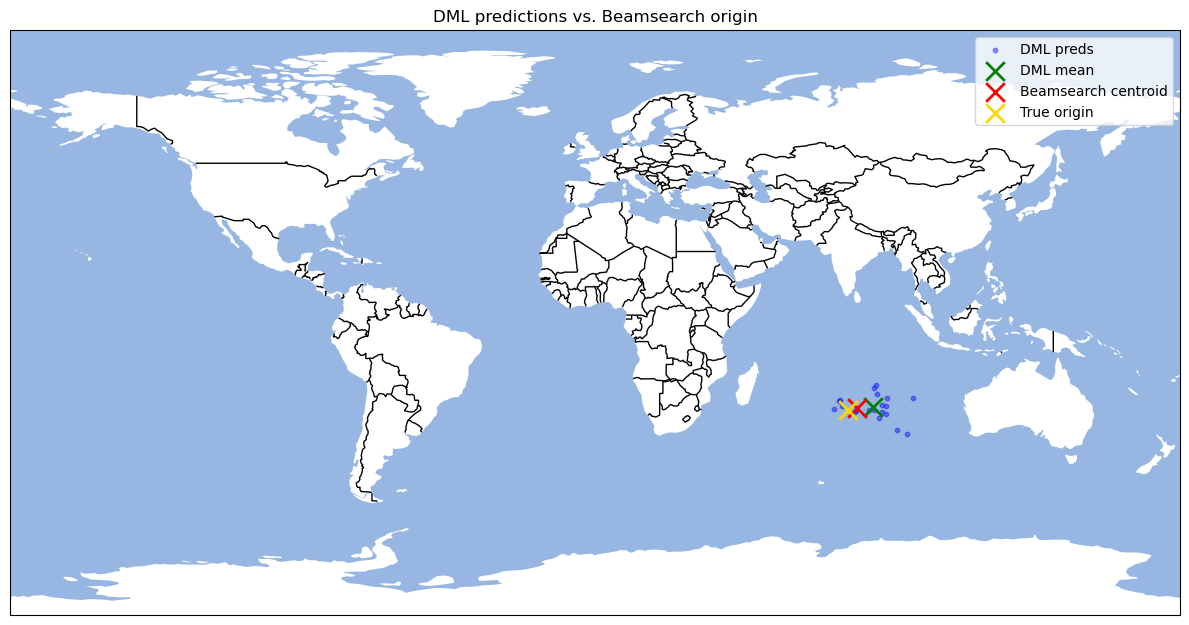

origin lat:     -26.8536157114
dml_mean  lat:  -26.002263494765
beamsearch lat: -26.231914306776474
origin lon:     77.8163761165
dml_mean  lon:  85.44893443111
beamsearch lon: 80.7200522629018


In [5]:
import matplotlib.pyplot as plt
from statistics import mean
import cartopy

origin_time = bulletin.loc[0,"ORIG_TIME"]
origin_lon = bulletin.loc[0,"ORIG_LON"]
origin_lat = bulletin.loc[0,"ORIG_LAT"]
dml_lat_mean = mean(dml_predictions.LAT_ORIG)
dml_lon_mean = mean(dml_predictions.LON_ORIG)
beamsearch_lon = float(centroid.split(',')[0][1:-1])


if centroid.split(',')[1] == '-':
    beamsearch_lat = float(centroid.split(',')[1][1:-1])
else:
    beamsearch_lat = float(centroid.split(',')[1][:-1])

plt.rcParams['figure.figsize'] = [12,12]
geo_axes = plt.axes(projection=cartopy.crs.PlateCarree())
geo_axes.add_feature(cartopy.feature.BORDERS)
geo_axes.add_feature(cartopy.feature.OCEAN)
geo_axes.scatter(dml_predictions['LON_ORIG'], dml_predictions['LAT_ORIG'], marker='.', s=40, linewidth=1, c='b', alpha=0.4, label="DML preds")
geo_axes.scatter(dml_lon_mean, dml_lat_mean, marker='x', linewidth=2, c='g', s=180, alpha=1, label="DML mean")
geo_axes.scatter(beamsearch_lon, beamsearch_lat, marker='x', linewidth=2, c='r', s=180, alpha=1, label="Beamsearch centroid")
geo_axes.scatter(origin_lon, origin_lat, marker='x', linewidth=2, c='gold', s=180, alpha=1, label="True origin")
geo_axes.set_global()

plt.title("DML predictions vs. Beamsearch origin")
plt.legend()
plt.tight_layout()
plt.show()

print("origin lat:    ", origin_lat)
print("dml_mean  lat: ", dml_lat_mean)
print("beamsearch lat:", beamsearch_lat)

print("origin lon:    ", origin_lon)
print("dml_mean  lon: ", dml_lon_mean)
print("beamsearch lon:", beamsearch_lon)

### Sample of iterating over entire bulletin

In [6]:
randl.set_bulletin_start('2024-05-01T00:00:00')
randl.set_bulletin_end('2024-05-01T2:00:00')
randl.set_bulletin_n_stations(50)
randl.set_bulletin_n_events(3)
randl.set_bulletin_drop_fraction(0.2)
randl.set_bulletin_seed(123)
bulletin = randl.create_bulletin()

Success


In [25]:
from dateutil import parser
from datetime import timedelta
import pandas as pd
origins = pd.DataFrame(columns=['Window_start', 'Window_end', 'DML_mean_lat', 'DML_mean_lon', 'Beamsearch_lat', 
                                'Beamsearch_lon', 'Beamsearch_time'])
window_length = 1800
randl.set_window_length(window_length)
randl.set_window_phases_required(5)
randl.set_window_exclude_associated_phases(False)

starttime = parser.parse(randl.bulletin_start)
bulletin_end = parser.parse(bulletin.TIME_ARRIV[len(bulletin)-1])

while starttime < bulletin_end:
    print("Starting window at", starttime.strftime('%Y-%m-%dT%H:%M:%S'))
    randl.set_window_start(starttime.strftime('%Y-%m-%dT%H:%M:%S'))
    window = randl.window_catalog(bulletin)
    
    try:
        print("Arrivals in window:", len(window))
        if len(window) > 0:

            window_end = parser.parse(window.TIME_ARRIV.iloc[len(window)-1])
            window_start = parser.parse(window.TIME_ARRIV.iloc[0])
            
            print("window_start", window_start)
            print("window_end", window_end)

            dml_predictions = randl.dml_prediction(window)

            centroid, mean_time, mean_score = randl.beamsearch(window, dml_predictions)

            dml_lat_mean = mean(dml_predictions.LAT_ORIG)
            dml_lon_mean = mean(dml_predictions.LON_ORIG)

            beamsearch_lon = float(centroid.split(',')[0][1:-1])


            if centroid.split(',')[1] == '-':
                beamsearch_lat = float(centroid.split(',')[1][1:-1])
            else:
                beamsearch_lat = float(centroid.split(',')[1][:-1])
            beamsearch_time = parser.parse(mean_time)

            result=pd.DataFrame()
            result['Window_start'] = [window_start]
            result['Window_end'] = [window_end]
            result['DML_mean_lat'] = [dml_lat_mean]
            result['DML_mean_lon'] = [dml_lon_mean]
            result['Beamsearch_lat'] = [beamsearch_lat]
            result['Beamsearch_lon'] = [beamsearch_lon]
            result['Beamsearch_time'] = [beamsearch_time]
            origins = pd.concat([origins, result], ignore_index=True)

            starttime += timedelta(seconds=window_length)

        else:
            starttime += timedelta(seconds=window_length)
            print("No arrivals. Moving window to start at", starttime.strftime('%Y-%m-%dT%H:%M:%S'))
    except Exception as e:
        starttime += timedelta(seconds=window_length)
        print(e)
        continue
        

Starting window at 2024-05-01T00:00:00
Success
Arrivals in window: 20
window_start 2024-05-01 00:19:21.955876
window_end 2024-05-01 00:24:31.128185
Success
Success
Starting window at 2024-05-01T00:30:00
Success
Arrivals in window: 0
No arrivals. Moving window to start at 2024-05-01T01:00:00
Starting window at 2024-05-01T01:00:00
Success
Arrivals in window: 42
window_start 2024-05-01 01:06:12.079697
window_end 2024-05-01 01:32:23.882610
Success
Success
Starting window at 2024-05-01T01:30:00
Success
Arrivals in window: 11
window_start 2024-05-01 01:30:20.037253
window_end 2024-05-01 01:32:23.882610
Success
Success


### Origins found:

In [26]:
origins

,Window_start,Window_end,DML_mean_lat,DML_mean_lon,Beamsearch_lat,Beamsearch_lon,Beamsearch_time
0,2024-05-01 00:19:21.955876,2024-05-01 00:24:31.128185,28.844647,128.191658,28.081319,127.586786,2024-05-01 00:13:04.519129
1,2024-05-01 01:06:12.079697,2024-05-01 01:32:23.882610,-53.227283,83.358143,-58.60452,119.926884,2024-05-01 01:03:50.979364
2,2024-05-01 01:30:20.037253,2024-05-01 01:32:23.882610,-31.174563,18.073548,-32.36486,18.087603,2024-05-01 01:20:41.096689


### Output from function calls

In [27]:
bulletin

,STA,LAT_STA,LON_STA,ARID,TIME_ARRIV,IPHASE,ORID,ORIG_TIME,ORIG_LAT,ORIG_LON,BACK_AZIMUTH
0,8,-3.432258,135.164463,0,2024-05-01 00:19:21.955876,P,2,2024-05-01 00:12:42.541092,29.081581,127.602896,0
1,21,62.897723,138.717657,1,2024-05-01 00:19:32.941068,P,2,2024-05-01 00:12:42.541092,29.081581,127.602896,0
2,14,-18.352034,123.243278,2,2024-05-01 00:21:20.244294,P,2,2024-05-01 00:12:42.541092,29.081581,127.602896,0
3,24,40.039809,-174.193486,3,2024-05-01 00:21:25.514002,P,2,2024-05-01 00:12:42.541092,29.081581,127.602896,0
4,40,22.311531,73.785179,4,2024-05-01 00:21:27.520357,P,2,2024-05-01 00:12:42.541092,29.081581,127.602896,0
...,...,...,...,...,...,...,...,...,...,...,...
59,1,-38.494920,117.482688,104,2024-05-01 01:31:51.161983,P,1,2024-05-01 01:19:59.696761,-32.043491,19.172644,0
60,41,-69.188689,178.329054,105,2024-05-01 01:31:57.738696,P,1,2024-05-01 01:19:59.696761,-32.043491,19.172644,0
61,23,19.984232,80.429889,106,2024-05-01 01:32:01.890799,P,1,2024-05-01 01:19:59.696761,-32.043491,19.172644,0
62,5,-13.840837,-70.516516,107,2024-05-01 01:32:23.882610,P,1,2024-05-01 01:19:59.696761,-32.043491,19.172644,0


In [28]:
window

,STA,LAT_STA,LON_STA,ARID,TIME_ARRIV,IPHASE,ORID,ORIG_TIME,ORIG_LAT,ORIG_LON,BACK_AZIMUTH,ORIG_DEPTH,assoc_id
52,39,0.330602,-36.653155,96,2024-05-01 01:30:20.037253,P,1,2024-05-01 01:19:59.696761,-32.043491,19.172644,0,0,-1
53,33,-1.136682,-39.977793,97,2024-05-01 01:30:32.070565,P,1,2024-05-01 01:19:59.696761,-32.043491,19.172644,0,0,-1
54,36,-13.256765,-51.336876,98,2024-05-01 01:30:51.846339,P,1,2024-05-01 01:19:59.696761,-32.043491,19.172644,0,0,-1
55,43,-15.331282,94.517213,99,2024-05-01 01:31:11.164232,P,1,2024-05-01 01:19:59.696761,-32.043491,19.172644,0,0,-1
56,17,-58.418684,-92.280105,100,2024-05-01 01:31:32.155578,P,1,2024-05-01 01:19:59.696761,-32.043491,19.172644,0,0,-1
57,11,41.228947,30.937159,102,2024-05-01 01:31:37.493505,P,1,2024-05-01 01:19:59.696761,-32.043491,19.172644,0,0,-1
58,29,23.575702,70.390630,103,2024-05-01 01:31:37.500082,P,1,2024-05-01 01:19:59.696761,-32.043491,19.172644,0,0,-1
59,1,-38.494920,117.482688,104,2024-05-01 01:31:51.161983,P,1,2024-05-01 01:19:59.696761,-32.043491,19.172644,0,0,-1
60,41,-69.188689,178.329054,105,2024-05-01 01:31:57.738696,P,1,2024-05-01 01:19:59.696761,-32.043491,19.172644,0,0,-1
61,23,19.984232,80.429889,106,2024-05-01 01:32:01.890799,P,1,2024-05-01 01:19:59.696761,-32.043491,19.172644,0,0,-1


In [29]:
dml_predictions

,ARID,STA,sampling,features,p_anchors,source_X_unscaled,source_Y_unscaled,source_Z_unscaled,Time_unscaled,LON_ORIG,LAT_ORIG,DEPTH_ORIG,Loc_uncertainty,T_uncertainty,model,TIME_ORIG
0,"[97, 102, 103, 107, 100]","[33, 11, 29, 5, 17]",kfn,"[0.7661437323, 0.6460245290000001, 0.307758265...",2024-05-01 01:30:32.070565,4.873684e+06,1.588555e+06,-2.842925e+06,592.042118,18.053140,-29.190789,-511470.323097,191.801113,18.662002,pwave,2024-05-01 01:20:40.028446689
1,"[97, 102, 107, 99, 106]","[33, 11, 5, 43, 23]",kfn,"[0.7661437323, 0.6460245290000001, 0.323912655...",2024-05-01 01:30:32.070565,4.953910e+06,1.555662e+06,-2.775607e+06,582.136130,17.433700,-28.300264,-485639.131690,220.426434,17.216979,pwave,2024-05-01 01:20:49.934434667
2,"[97, 102, 107, 105, 104]","[33, 11, 5, 41, 1]",kfn,"[0.7661437323, 0.6460245290000001, 0.323912655...",2024-05-01 01:30:32.070565,4.657321e+06,1.705268e+06,-3.067947e+06,594.023573,20.110100,-31.928390,-540310.096202,170.632012,14.282669,pwave,2024-05-01 01:20:38.046991601
3,"[103, 97, 100, 105, 99]","[29, 33, 17, 41, 43]",kfn,"[0.3077582652, 0.7661437323, -0.0208864422, -0...",2024-05-01 01:30:32.070565,4.841939e+06,1.443072e+06,-3.055400e+06,600.742346,16.595945,-31.347338,-467956.320559,197.505905,14.395602,pwave,2024-05-01 01:20:31.328218952
4,"[107, 106, 105, 104, 96]","[5, 23, 41, 1, 39]",kfn,"[0.3239126559, 0.1563047665, -0.3561836729, -0...",2024-05-01 01:30:20.037253,4.720484e+06,1.532925e+06,-3.114412e+06,577.566236,17.990632,-32.297332,-512686.040634,193.437410,12.402079,pwave,2024-05-01 01:20:42.471016742
5,"[107, 106, 105, 104, 97]","[5, 23, 41, 1, 33]",kfn,"[0.3239126559, 0.1563047665, -0.3561836729, -0...",2024-05-01 01:30:32.070565,4.712400e+06,1.533793e+06,-3.126947e+06,590.481985,18.029042,-32.440141,-512242.471279,197.413822,12.821838,pwave,2024-05-01 01:20:41.588580385
6,"[107, 106, 105, 104, 98]","[5, 23, 41, 1, 36]",kfn,"[0.3239126559, 0.1563047665, -0.3561836729, -0...",2024-05-01 01:30:51.846339,4.700485e+06,1.554744e+06,-3.157504e+06,610.924709,18.302277,-32.717686,-499823.771232,200.663141,12.297393,pwave,2024-05-01 01:20:40.921630157


In [30]:
centroid

'(18.087603241738147, -32.36486042869398)'